In [24]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import display
import skimage.segmentation as seg
import skimage.color as color
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.util import img_as_float

import skimage
from skimage import io
from skimage.color import rgb2gray
import skimage.segmentation as seg
from scipy import ndimage
import skimage.morphology as morph
from skimage.feature import peak_local_max
from skimage import filters
from skimage.morphology import disk, ball
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.segmentation import flood, flood_fill
from PIL import Image, ImageDraw, ImageFilter
import copy
import cv2


In [25]:
def img_show(image,N=20,cmap=plt.cm.nipy_spectral):
    
    plt.figure(figsize=(N,N))
    plt.axis('off')
    plt.imshow(image,cmap=cmap)
    plt.show()

def imdivide(image,side):
    
    width,height = image.size
    sides={'left':0,'right':1}
    shape=[(0,0,width//2,height),(width//2,0,width,height)]
    return image.crop(shape[sides[side]])
 
def combine(image,k=0.5,N=20): 
    left_img=imdivide(image,'left')
    right_img=imdivide(image,'right')

    l=k
    r=1-l
    gray=np.array(left_img)*l
    gray+=np.array(right_img)*r
    gray=gray.astype('uint8')
    return gray

def do_otsu(img,N=20):
    image=rgb2gray(img)
    
    global_thresh=skimage.filters.threshold_otsu(image)
    binary_global = image > global_thresh
    
    return binary_global
    

In [26]:
grain1_name='Ultra_Co6_2-040.jpg'
grain2_name='Ultra_Co11-2.jpg'
grain3_name='Ultra_Co25-1.jpg'

path='images'

grain1=io.imread(path+'/'+grain1_name).astype('uint8')
grain2=io.imread(path+'/'+grain2_name).astype('uint8')
grain3=io.imread(path+'/'+grain3_name).astype('uint8')

grain1_pil=Image.open(path+'/'+grain1_name)
grain2_pil=Image.open(path+'/'+grain2_name)
grain3_pil=Image.open(path+'/'+grain3_name)

## Выделение пустот

denoised=mean_filter(image)

binary=otsu(denoised)

grad=gradient(binary)

bin_grad=-binary+grad

In [35]:
combined1=combine(grain1_pil,0.5,10)
combined2=combine(grain2_pil,0.5,10)
combined3=combine(grain3_pil,0.5,10)

denoised1 = filters.rank.median(combined1, disk(3))
denoised2 = filters.rank.median(combined2, disk(3))
denoised3 = filters.rank.median(combined3, disk(3))

binary1=do_otsu(denoised1).astype('uint8')
binary2=do_otsu(denoised2).astype('uint8')
binary3=do_otsu(denoised3).astype('uint8')

grad1 = filters.rank.gradient(binary1, disk(1))
grad2 = filters.rank.gradient(binary2, disk(1))
grad3 = filters.rank.gradient(binary3, disk(1))

bin_grad1=1-binary1+grad1
bin_grad2=1-binary2+grad2
bin_grad3=1-binary3+grad3

C:\Users\Администратор\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:27: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


## Маркировка углов

In [36]:
def mark_corners(image):
    image=copy.copy(image)
    corners = cv2.goodFeaturesToTrack(image, 1000000, 0.1, 12)

    corners = np.int0(corners)
    print('number of corners: ',len(corners))
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 3, 255, -1)
    x=copy.copy(corners[:,0,1])
    y=copy.copy(corners[:,0,0])
    corners[:,0,0],corners[:,0,1]=x,y
    del x
    del y
    return image,corners

def mark_classes(image):
    classes = filters.rank.gradient(image, disk(1)) < 250
    classes,num = ndi.label(classes)
    print('number of classes:',num)
    return classes,num


In [37]:
grain1_marked,grain1_corners=mark_corners(bin_grad1*127)
grain2_marked,grain2_corners=mark_corners(bin_grad2*127)
grain3_marked,grain3_corners=mark_corners(bin_grad3*127)

grain1_classes,class1_num=mark_classes(bin_grad1*127)
grain2_classes,class2_num=mark_classes(bin_grad2*127)
grain3_classes,class3_num=mark_classes(bin_grad3*127)

number of corners:  244
number of corners:  1244
number of corners:  3619
number of classes: 184
number of classes: 337
number of classes: 1218


## Отметим наличие углов для каждого класса пустоты

In [38]:

shape=(class2_num+1,200)
classes=grain2_classes
corners=grain2_corners
nodes=np.zeros(shape)

num1=0
num0=0
r=2
for i,corner in enumerate(corners):
    x=corner[0][0]
    y=corner[0][1]
    cls=classes[x,y]
    real_cls=0
    flag=True
    while flag:
        for xi in range(x-r,x+r):
            for yi in range(y-r,y+r):
                if classes[xi,yi]!=0 and classes[xi,yi]!=1:
                    real_cls=classes[xi,yi]
                    flag=False
    if real_cls==1:
        num1+=1
    elif real_cls==0:
        num0+=1
    else:
        index=np.where(nodes[real_cls]==0)[0][0]
        nodes[real_cls,index]=i


print('class 0 number',num0)
print('class 1 number',num1)

class 0 number 0
class 1 number 0


## Подсчитаем количество пустот, в которое входит угол

In [39]:
corner_distr=np.zeros((corners.shape[0]))
for i in range(corners.shape[0]):
    for node in nodes:
        if i in node:
            corner_distr[i]+=1

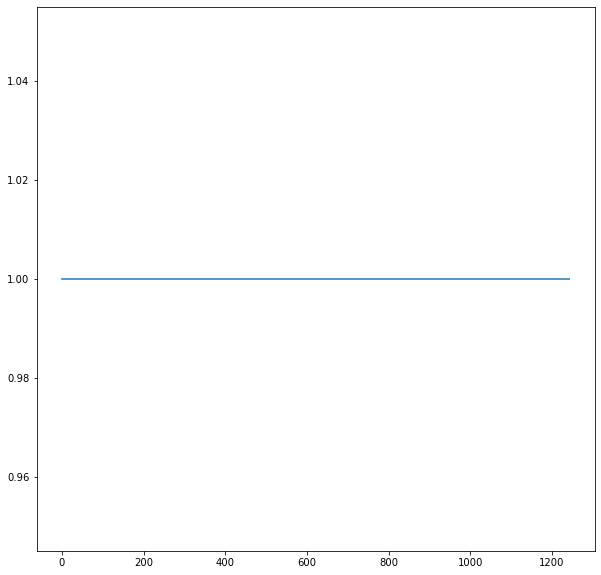

In [40]:
plt.figure(figsize=(10,10))
plt.plot(corner_distr[1:])